# In this file we generate the dataset for the calibration of the rBergomi model with flat forward variance for the pointwise random grids approach
In the forward pass we learn the **mapping** between **rBergomi parameters** and the option **implied volatility**, In this case the implied volatility surface is on an adaptive random grid 13(strikes)x11(maturities) a bit larger than the one used for the image based approach.

 In order to make a fair comparison we will consider a subset of 20000 parameters sets, due to MC computational time, then we will generate the random grids and create the dataset.
 
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rBergomi/flat forward variance/random grids")

In [2]:
#import libraries
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from rbergomi import rBergomi
from utils import implied_volatility, bs, bsinv
#Open compressed dataset

f = gzip.GzipFile('rBergomiTrainSet.txt.gz',"r")
dat=np.load(f) #load data in a numpy array
xx=dat[:,:4]   #extract first 4 columns (rBergomi parameters)

np.random.seed(42) # Fix seed for reproducibility

# 1. Select 20k random indices
n_samples = 20000
random_indices = np.random.choice(len(xx), size=n_samples, replace=False)

# 2. Extract corresponding parameters
xx = xx[random_indices]  # Shape (20000, 4)

# Print shapes with descriptive messages
print("\nInput (rBergomi parameter sets) shape (samples × 4 parameters):", xx.shape)
print("  - Each row contains: [ξ₀, ν, ρ, H]")


Input (rBergomi parameter sets) shape (samples × 4 parameters): (20000, 4)
  - Each row contains: [ξ₀, ν, ρ, H]


# Let's have a look at the parameters sets and gain some more informations


=== rBergomi PARAMETERS ANALYSIS (xx) ===
       ξ₀ (flat forward variance)  ν (influences smile)  \
count                  20000.0000            20000.0000   
mean                       0.0881                2.2098   
std                        0.0422                1.0544   
min                        0.0100                0.3000   
1%                         0.0123                0.3424   
5%                         0.0204                0.5197   
50%                        0.0888                2.2330   
95%                        0.1529                3.8248   
99%                        0.1585                3.9612   
max                        0.1600                3.9996   

       ρ (spot-vol correlation)  H (Hurst exponent)  
count                20000.0000          20000.0000  
mean                    -0.5128              0.2594  
std                      0.2398              0.1370  
min                     -0.9499              0.0250  
1%                      -0.9371      

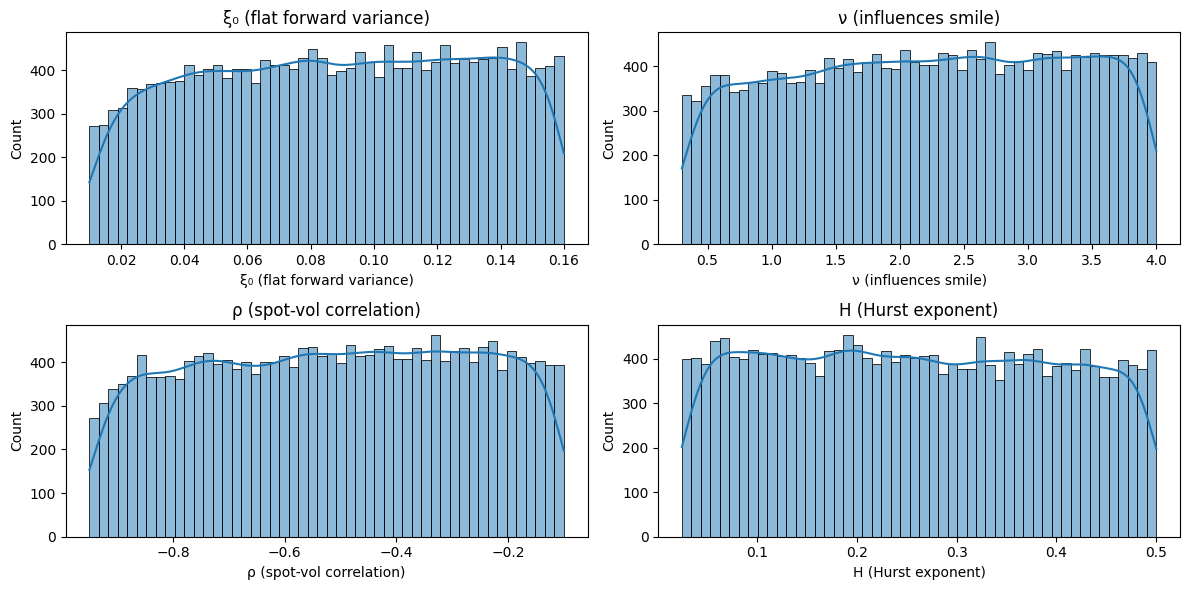

In [3]:
import seaborn as sns

#INPUT (rBergomi PARAMETERS) ANALYSIS 

# rBergomi parameter names (for clarity)
#ξ₀  ∈ [0.01, 0.16]        (flat forward variance)
#ν   ∈ [0.3, 4.0]          (influences smile)
#ρ   ∈ [-0.95, -0.1]       (spot-vol correlation)
#H   ∈ [0.025, 0.5]        (Hurst exponent)

param_names = [
    'ξ₀ (flat forward variance)',
    'ν (influences smile)',
    'ρ (spot-vol correlation)',
    'H (Hurst exponent)',
]



# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx, columns=param_names)

# Descriptive statistics
print("\n=== rBergomi PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ξ₀:    Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.01, 0.16])")
print(f"ρ:   Min={df_xx.iloc[:,2].min():.4f}, Max={df_xx.iloc[:,2].max():.4f} (Expected: ~[-0.95, -0.1])")
print(f"H: Min={df_xx.iloc[:,3].min():.4f}, Max={df_xx.iloc[:,3].max():.4f} (Expected: ~[0.025, 0.5])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Step 1: Data Generation


## **Inputs:** 
###  1. $\xi_{0}$ flat forward variance
###  2. $\nu$ smile effect
###  3. $\rho$ spot-vol correlation
###  4. $H$ Hurst exponent
###  5. $K$ option strike price
###  6. $T$ option maturity
    
    
## **Output:**
### Option Implied volatility 

# Generate the random grids
We will associate each parameter set $\theta -> (K_i,T_j)_{i=1,..13}^{j=1,..,11}$ a unique random grid of couples of 11 maturities, each one uniformly sampled from a specified interval, for each maturity we will generate 13 strikes which will depend on the maturity (the longer, the more distanced the strikes)

In [11]:
def generate_random_rBergomi_grids(combined_params, S0=1.0, l=0.55, u=0.3):
    """
    Generates random grids for rBergomi parameters following specified rules.
    
    Args:
        combined_params: numpy array of rBergomi parameters (16000, 4) [ξ₀, ν, ρ, H]
        S0: initial price (default 1.0)
        l: lower bound multiplier (default 0.55)
        u: upper bound multiplier (default 0.3)
        
    Returns:
        numpy array of shape (16000*143, 6) with columns: [ξ₀, ν, ρ, H, strike, maturity]
    """
    # Define maturity intervals (11 intervals)
    maturity_intervals = [
        (0.003, 0.03), (0.03, 0.09), (0.09, 0.15), (0.15, 0.3), (0.3, 0.5),
        (0.5, 0.75), (0.75, 1.0), (1.0, 1.25), (1.25, 1.5), (1.5, 2.0), (2.0, 2.5)
    ]
    
    num_samples = combined_params.shape[0]
    num_points_per_sample = 11 * 13  # 11 maturities × 13 strikes each
    total_points = num_samples * num_points_per_sample
    
    # Initialize output array
    output = np.zeros((total_points, 6))
    
    for i in range(num_samples):
        # Get current rBergomi parameters
        rBergomi_params = combined_params[i]
        
        # Generate points for this parameter set
        points = np.zeros((num_points_per_sample, 6))
        
        for j, (t_min, t_max) in enumerate(maturity_intervals):
            # Generate random maturity in this interval
            T = np.random.uniform(t_min, t_max)
            
            # Calculate strike bounds
            sqrt_T = np.sqrt(T)
            K_min = S0 * (1 - l * sqrt_T)
            K_max = S0 * (1 + u * sqrt_T)
            K_mid_low = S0 * (1 - 0.2 * sqrt_T)
            K_mid_high = S0 * (1 + 0.2 * sqrt_T)
            
            # Generate strikes according to specified distribution
            # 4 strikes in [K_min, K_mid_low]
            strikes_low = np.random.uniform(K_min, K_mid_low, 4)
            strikes_low = np.sort(strikes_low)   #sort the strikes
            
            # 7 strikes in [K_mid_low, K_mid_high]
            strikes_mid = np.random.uniform(K_mid_low, K_mid_high, 7)
            strikes_mid = np.sort(strikes_mid)   #sort the strikes

            # 2 strikes in [K_mid_high, K_max]
            strikes_high = np.random.uniform(K_mid_high, K_max, 2)
            strikes_high = np.sort(strikes_high)   #sort the strikes
            # Combine all strikes
            strikes = np.concatenate([strikes_low, strikes_mid, strikes_high])
            
            # Create points for this maturity
            start_idx = j * 13
            end_idx = (j + 1) * 13
            
            # Fill rBergomi parameters
            points[start_idx:end_idx, :4] = rBergomi_params
            
            # Fill strikes
            points[start_idx:end_idx, 4] = strikes
            
            # Fill maturity
            points[start_idx:end_idx, 5] = T
        
        # Add to output array
        output[i*num_points_per_sample:(i+1)*num_points_per_sample] = points
    
    return output

random_grid_data = generate_random_rBergomi_grids(xx)
print(f"Random grid dataset shape: {random_grid_data.shape}") # Output shape will be (16000*143, 6) = (2,288,000, 6)

# Print the first two rows as example
print("First two rows of the generated dataset:")
print("Columns: [ξ₀, ν, ρ, H, strike, maturity]")
for i in range(2):
    print(f"Row {i+1}: {random_grid_data[i]}")

Random grid dataset shape: (2860000, 6)
First two rows of the generated dataset:
Columns: [ξ₀, ν, ρ, H, strike, maturity]
Row 1: [ 0.104704    0.564144   -0.742971    0.244174    0.92370954  0.02036759]
Row 2: [ 0.104704    0.564144   -0.742971    0.244174    0.93699901  0.02036759]


Now we have to compute the EU vanilla call prices through **MC simulations** to have the ground truth of the forward pass, at the end of the notebook there's a step by step guide of the simulation of the **price process paths under rBergomi** and an example of EU call pricing

In [4]:
maturity_list = [
    [0.003, 0.03],
    [0.03, 0.09],
    [0.09, 0.15],
    [0.15, 0.3],
    [0.3, 0.5],
    [0.5, 0.75],
    [0.75, 1],
    [1, 1.25],
    [1.25, 1.5],
    [1.5, 2],
    [2, 2.5]
]

def find_interval(T):
    for i, interval in enumerate(maturity_list):
        if interval[0] <= T < interval[1]:
            return i 
        
print(find_interval(0.02))

0


In [5]:
#Utility function to find the adaptive number of steps per year per maturity, ensures adaptive granularity for different maturities
steps = np.array([10]*3 + [18]*6 + [30, 30], dtype=int)
steps = np.cumsum(steps)

def compute_steps_for_maturity(T, steps=steps):
    """
    Compute number of steps per year (n) for a given maturity using a fixed number
    of total steps per maturity interval.
    
    Args:
        T: Maturity for which we want n
        steps: contains total number of steps per maturity intevral
        
    Returns:
        n: Steps per year for this maturity
    """
    idx = find_interval(T)
    s = steps[idx]
    return int(np.ceil(s/T))

print(compute_steps_for_maturity(1.0))

120


In [7]:
def MC_Call_Mixed(params, K, T,N=50000, r=0.0, S0=1.0):
    """
    Monte Carlo simulation for call options under rBergomi model with implied vol calculation
    
    Args:
        params: Array [ξ₀, ν, ρ, H] (variance params, correlation, Hurst exponent)
        K: Array of strike prices
        T: Time to maturity
        N: Number of MC paths (default 60,000)
        r: Risk-free rate (default 0.0)
        S0: Initial spot price (default 1.0)
        
        
    Returns:
        Array of implied volatilities for each strike
    """
    # Dynamically adjust the number of steps per year, crucial for short maturities
    n_steps = compute_steps_for_maturity(T)
    
    xi, nu, rho, H = params

    rB = rBergomi(n = n_steps, N = N, T = T, H = H)
    dW1 = rB.dW1()
    Ya = rB.Y(dW1)
    V = rB.V(Ya, xi = xi, nu = nu) 
    S1 = rB.S1(V, dW1, rho = rho)


    QV = np.sum(V, axis = 1)[:,np.newaxis] * rB.dt
    Q = np.max(QV) + 1e-9
    S1T = S1[:,-1][:,np.newaxis]
    X = bs(S1T, K, (1 - rho**2) * QV)
    Y = bs(S1T, K, rho**2 * (Q - QV))
    eY = bs(1., K, rho**2 * Q)
    m = len(K)
    c = np.zeros(m)
    for i in range(m):
        cov_mat = np.cov(X[:, i], Y[:, i])
        denom = cov_mat[1, 1]
        if denom == 0.0:
            c[i] = 0.0
        else:
            c[i] = - cov_mat[0, 1] / denom

    # mixed payoffs and prices
    mixed_payoffs = X + (c[None, :] * (Y - eY[None, :]))  # (N, m)
    mixed_prices = np.mean(mixed_payoffs, axis=0)          # (m,)
    mixed_prices = np.maximum(mixed_prices, 1e-12)

    mixed_ivs = np.array([bsinv(p, 1.0, k, T) for p, k in zip(mixed_prices, K)])  # (m,)
    return mixed_ivs

Now we compute the implied volatilities for all the options, thanks to the MC simulations we're able to process all the 13 strikes for a given maturity, making this procedure 13 times faster with respect to truly pointwise approaches

In [8]:
from tqdm import tqdm  # For progress bar

def calculate_all_implied_vols(random_grid_data, S0=1.0, r=0.0):
    """
    Calculate implied volatilities for all option points in the random grid dataset.
    
    Args:
        random_grid_data: numpy array of shape (N*143, 6) with columns:
                         [ξ₀, ν, ρ, H, strike, maturity]
        S0: initial spot price (default 1.0)
        r: risk-free rate (default 0.0)
        
    Returns:
        Tuple of (implied_vols_array, valid_indices) where:
        - implied_vols_array: array of shape (N*143,) with IVs (NaN where calculation failed)
        - valid_indices: indices of points where IV calculation succeeded
    """
    num_samples = len(random_grid_data) // 143
    implied_vols = np.full(len(random_grid_data), np.nan)
    
    # Process each parameter set (each 143 options)
    for i in tqdm(range(num_samples), desc="Processing parameter sets"):
        # Get current parameter set and all its options
        start_idx = i * 143
        end_idx = (i + 1) * 143
        current_batch = random_grid_data[start_idx:end_idx]
        
        # Extract parameters (same for all 143 options)
        params = current_batch[0, :4]
        
        # Group options by maturity for efficient MC pricing
        unique_maturities = np.unique(current_batch[:, 5])
        
        for T in unique_maturities:
            # Get all strikes for this maturity
            maturity_mask = current_batch[:, 5] == T
            strikes = current_batch[maturity_mask, 4]
            
            # Price all options for this maturity with single MC call
            try:
                ivs = MC_Call_Mixed(params, strikes, T)
                
                # Store results at the correct positions
                implied_vols[start_idx:end_idx][maturity_mask] = ivs
            except Exception as e:
                print(f"\nError processing parameter set {i+1}, maturity {T:.4f}: {str(e)}")
                continue
    
    # Identify valid results (non-NaN)
    valid_indices = np.where(~np.isnan(implied_vols))[0]
    
    print(f"\nCalculation completed. Success rate: {len(valid_indices)/len(implied_vols):.2%}")
    return implied_vols, valid_indices

implied_vols, valid_idx = calculate_all_implied_vols(random_grid_data)

Processing parameter sets:   0%|          | 57/20000 [14:34<86:42:43, 15.65s/it] C:\Users\pc\Desktop\politecnico\TESI\mio codice\rBergomi\flat forward variance\random grids\utils.py:36: RuntimeWarning: divide by zero encountered in log
  d1 = np.log(F/K) / sv + 0.5 * sv
Processing parameter sets: 100%|██████████| 20000/20000 [79:50:33<00:00, 14.37s/it]   


Calculation completed. Success rate: 100.00%


In [9]:
# QUICK ANALYISIS OF IMPLIED VOLATILITIES COMPUTATION
failed_mask = np.isnan(implied_vols)
num_failed = failed_mask.sum()

if num_failed > 0:
    failed_points = random_grid_data[failed_mask]
    
    # Get unique parameter sets with at least one failure
    failed_params = np.unique(failed_points[:, :4], axis=0)
    num_failed_paramsets = len(failed_params)
    
    print("\nDiagnostic Summary:")
    print(f"Total failed calculations: {num_failed}")
    print(f"Unique parameter sets with failures: {num_failed_paramsets}")
else:
    print("\nAll calculations succeeded!")


Diagnostic Summary:
Total failed calculations: 8
Unique parameter sets with failures: 6


In [10]:
# NEED TO HANDLE FAILURES IN IMPLIED VOLATILITY COMPUTATION, ENSURE DATA QUALITY
# Cut out parameters sets with failures.

def keep_only_perfect_blocks(random_grid_data, implied_vols, points_per_sample=143):
    """
    Strict cleaning that only keeps parameter sets with ALL 143 implied volatilities valid.
    
    Args:
        random_grid_data: (N*143, 6) array of [params, strike, maturity]
        implied_vols: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
        
    Returns:
        clean_data: (M*143, 6) array with complete blocks only
        clean_ivs: (M*143,) array without any NaNs
        n_dropped: Number of full parameter sets dropped
    """
    n_samples = len(random_grid_data) // points_per_sample
    clean_data = []
    clean_ivs = []
    n_dropped = 0
    
    for i in range(n_samples):
        block_start = i * points_per_sample
        block_end = (i+1) * points_per_sample
        block_ivs = implied_vols[block_start:block_end]
        
        # Keep only if ALL IVs are valid
        if not np.isnan(block_ivs).any():
            clean_data.append(random_grid_data[block_start:block_end])
            clean_ivs.append(block_ivs)
        else:
            n_dropped += 1
    
    # Combine results if we found valid blocks
    if clean_data:
        final_data = np.vstack(clean_data)
        final_ivs = np.concatenate(clean_ivs)
    else:
        final_data = np.empty((0, 6))
        final_ivs = np.empty((0,))
    
    print("\nStrict cleaning results:")
    print(f"Complete blocks kept: {len(clean_data)}/{n_samples}")
    print(f"Blocks dropped: {n_dropped}")
    print(f"Final dataset size: {len(final_ivs)} options ({final_data.shape[0]//points_per_sample} parameter sets)")
    
    return final_data, final_ivs, n_dropped

# Usage example:
clean_data, clean_ivs, n_dropped = keep_only_perfect_blocks(random_grid_data, implied_vols)


Strict cleaning results:
Complete blocks kept: 19994/20000
Blocks dropped: 6
Final dataset size: 2859142 options (19994 parameter sets)


=== Dataset Integrity Checks ===
NaN in clean_data: False
NaN in clean_ivs: False
IV range: [0.0000, 0.6166]

=== Parameter Set Validation ===
Found 19994 unique parameter sets

=== Option Structure Validation ===
Maturities per set: 11 (expected: 11)
Options per maturity: 13 (expected: 13)

=== First Parameter Set Sample ===
Parameters: [ 0.104704  0.564144 -0.742971  0.244174]
First 5 options:
K=0.9236 | T=0.0286 | IV=0.3594
K=0.9419 | T=0.0286 | IV=0.3541
K=0.9485 | T=0.0286 | IV=0.3522
K=0.9603 | T=0.0286 | IV=0.3488
K=0.9723 | T=0.0286 | IV=0.3453
IV Statistics:
- Total points: 2859142
- Valid IV [0-1]: 2859142 (100.00%)
- Negative IV: 0 (0.00%)
- IV > 1: 0 (0.00%)


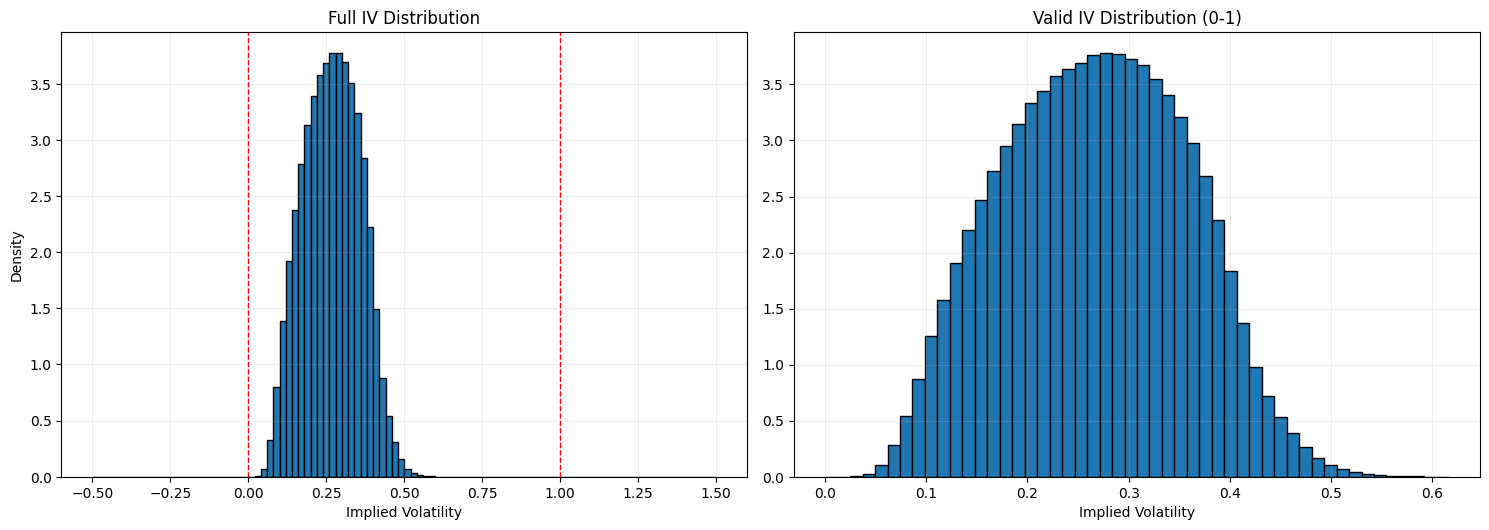

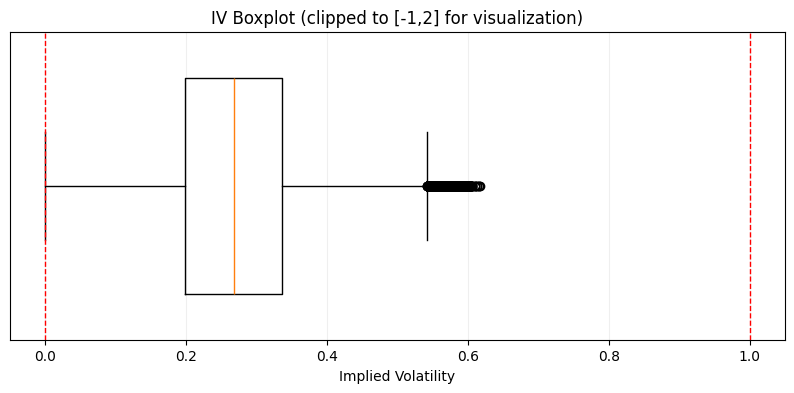

In [11]:
# HAVE MORE INSIGHTS ON THE DATA AND THE DISTRIBUTION OF IMPLIED VOLATILITIES
#================================================================================

def verify_clean_dataset(clean_data, clean_ivs, points_per_sample=143):
    """
    Performs comprehensive validation on cleaned dataset:
    1. Checks for remaining NaN values
    2. Validates implied volatility range (0-1)
    3. Verifies parameter set ordering consistency
    4. Checks maturity/strike structure
    
    Args:
        clean_data: (N*143, 6) array of [params, strike, maturity]
        clean_ivs: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
    """
    # --- Basic Integrity Checks ---
    print("=== Dataset Integrity Checks ===")
    print(f"NaN in clean_data: {np.isnan(clean_data).any()}")
    print(f"NaN in clean_ivs: {np.isnan(clean_ivs).any()}")
    print(f"IV range: [{clean_ivs.min():.4f}, {clean_ivs.max():.4f}]")
    
    # --- Parameter Set Consistency ---
    print("\n=== Parameter Set Validation ===")
    sample_params = clean_data[::points_per_sample, :4]  # Get first row of each block
    unique_params = np.unique(sample_params, axis=0)
    print(f"Found {len(unique_params)} unique parameter sets")
    
    # --- Strike/Maturity Structure Verification ---
    print("\n=== Option Structure Validation ===")
    first_block = clean_data[:points_per_sample]
    maturities, counts = np.unique(first_block[:,5], return_counts=True)
    print(f"Maturities per set: {len(maturities)} (expected: 11)")
    print(f"Options per maturity: {counts[0]} (expected: 13)")
    
    # --- Sample Data Inspection ---
    print("\n=== First Parameter Set Sample ===")
    print("Parameters:", clean_data[0,:4])
    print("First 5 options:")
    for i in range(5):
        print(f"K={clean_data[i,4]:.4f} | T={clean_data[i,5]:.4f} | IV={clean_ivs[i]:.4f}")

def analyze_iv_distribution(clean_ivs):
    """
    Comprehensive analysis of implied volatility distribution:
    - Statistical summary
    - Visualization of valid/invalid ranges
    - Outlier detection
    
    Args:
        clean_ivs: Array of implied volatilities
    """
    # --- Statistical Analysis ---
    stats = {
        'total': len(clean_ivs),
        'valid': np.sum((clean_ivs >= 0) & (clean_ivs <= 1)),
        'negative': np.sum(clean_ivs < 0),
        'excessive': np.sum(clean_ivs > 1)
    }
    
    print(f"IV Statistics:\n"
          f"- Total points: {stats['total']}\n"
          f"- Valid IV [0-1]: {stats['valid']} ({stats['valid']/stats['total']:.2%})\n"
          f"- Negative IV: {stats['negative']} ({stats['negative']/stats['total']:.2%})\n"
          f"- IV > 1: {stats['excessive']} ({stats['excessive']/stats['total']:.2%})")

    # --- Visualization ---
    plt.figure(figsize=(15,10))
    
    # Main distribution plot
    plt.subplot(2,2,1)
    plt.hist(clean_ivs, bins=100, range=(-0.5,1.5), density=True, edgecolor='k')
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('Full IV Distribution')
    plt.xlabel('Implied Volatility')
    plt.ylabel('Density')
    plt.grid(alpha=0.2)

    # Valid range zoom
    plt.subplot(2,2,2)
    valid_ivs = clean_ivs[(clean_ivs >=0) & (clean_ivs <=1)]
    plt.hist(valid_ivs, bins=50, density=True, edgecolor='k')
    plt.title('Valid IV Distribution (0-1)')
    plt.xlabel('Implied Volatility')
    plt.grid(alpha=0.2)

    # Negative IVs (if any)
    if stats['negative'] > 0:
        plt.subplot(2,2,3)
        plt.hist(clean_ivs[clean_ivs<0], bins=max(5, stats['negative']//10), edgecolor='k')
        plt.title('Negative IV Distribution')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    # Excessive IVs (if any)
    if stats['excessive'] > 0:
        plt.subplot(2,2,4)
        plt.hist(clean_ivs[clean_ivs>1], bins=max(5, stats['excessive']//10), edgecolor='k')
        plt.title('Excessive IV Distribution (>1)')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    # --- Outlier Analysis ---
    plt.figure(figsize=(10,4))
    boxplot_data = clean_ivs[(clean_ivs >= -1) & (clean_ivs <= 2)]
    plt.boxplot(boxplot_data, vert=False, widths=0.7)
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('IV Boxplot (clipped to [-1,2] for visualization)')
    plt.xlabel('Implied Volatility')
    plt.yticks([])
    plt.grid(alpha=0.2)
    plt.show()

# Example usage
verify_clean_dataset(clean_data, clean_ivs)
analyze_iv_distribution(clean_ivs)

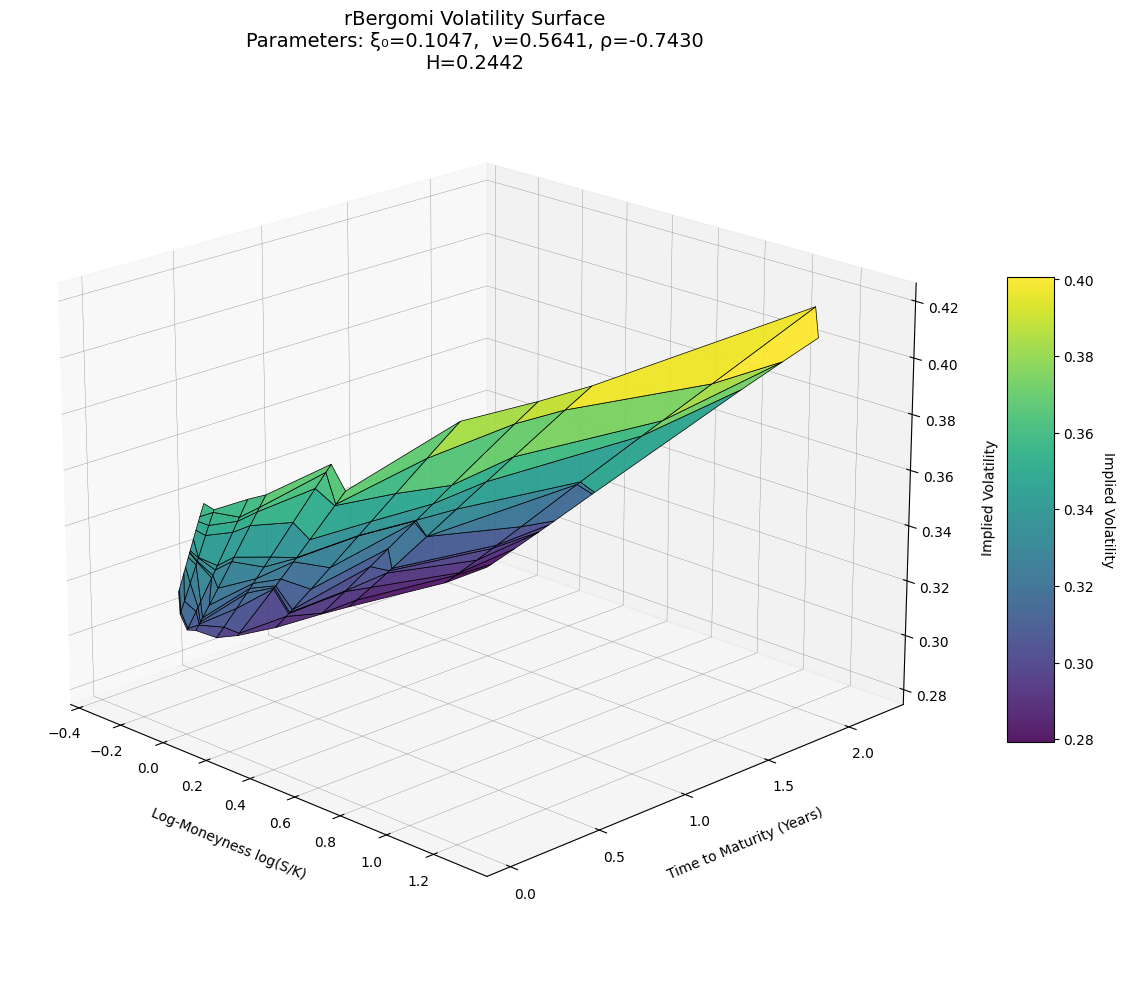

In [12]:
# PLOT ONE IMPLIED VOLATILITY SURFACE
from mpl_toolkits.mplot3d import Axes3D


def plot_rBergomi_vol_surface(data, ivs, S0=1.0, param_set_idx=0, points_per_set=143, 
                           use_log_moneyness=True, show_implied_vols=True):
    """
    Plots a 3D volatility surface for a specific rBergomi parameter set.
    
    Args:
        data: Full dataset array (N*143,6) with columns [ξ₀, ν, ρ, H,strike,maturity]
        ivs: Implied volatilities array (N*143,)
        param_set_idx: Index of parameter set to visualize (default: 0)
        points_per_set: Number of options per parameter set (default: 143)
        use_log_moneyness: Whether to plot log(K/S0) instead of strikes (default: True)
        show_implied_vols: Whether to show IV values on hover (default: True)
    """
    # Extract the specific parameter set's options
    start_idx = param_set_idx * points_per_set
    end_idx = (param_set_idx + 1) * points_per_set
    param_set = data[start_idx:end_idx]
    param_ivs = ivs[start_idx:end_idx]
    
    # Get parameters for title
    params = param_set[0, :4]
    
    # Prepare grid structure (11 maturities × 13 strikes)
    strikes = param_set[:, 4].reshape(11, 13)
    maturities = param_set[:, 5].reshape(11, 13)
    iv_matrix = param_ivs.reshape(11, 13)
    
    # Calculate log-moneyness if requested
    if use_log_moneyness:
        x_axis = np.log(S0/strikes)  # log(S0/K)
        x_label = "Log-Moneyness log(S/K)"
    else:
        x_axis = strikes
        x_label = "Strike Price K"
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(x_axis, maturities, iv_matrix, 
                          cmap='viridis', edgecolor='k', alpha=0.9,
                          linewidth=0.5, antialiased=True)
    
    # Add colorbar
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=15)
    
    # Customize view angle
    ax.view_init(elev=20, azim=-45)
    
    # Labels and title
    ax.set_xlabel(x_label, labelpad=12)
    ax.set_ylabel('Time to Maturity (Years)', labelpad=12)
    ax.set_zlabel('Implied Volatility', labelpad=12)
    
    title = (f"rBergomi Volatility Surface\n"
             f"Parameters: ξ₀={params[0]:.4f},  ν={params[1]:.4f}, ρ={params[2]:.4f}\n"
             f"H={params[3]:.4f}")
    plt.title(title, y=1.05, fontsize=14)
    
    # Add grid lines
    ax.xaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    
    # Add strike values on x-axis (every 2nd strike to avoid clutter)
    if not use_log_moneyness:
        ax.set_xticks(strikes[0, ::2])
        ax.set_xticklabels([f"{k:.2f}" for k in strikes[0, ::2]], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have loaded your data:
# data = np.loadtxt("rBergomiRandomGridsDataset.csv", delimiter=",")
# params = data[:, :5]
# strikes = data[:, 5]
# maturities = data[:, 6]
# ivs = data[:, 7]

# Plot with log-moneyness
plot_rBergomi_vol_surface(random_grid_data, implied_vols, param_set_idx=0, use_log_moneyness=True)

In [13]:
# Save the entire dataset (useful)
def save_rBergomi_dataset(clean_data , clean_ivs, filename="rBergomiflatRandomGridsDataset.csv"):
    """
    Save the complete rBergomi dataset (parameters + strikes + maturities + implied vols) to a CSV file.
    
    Args:
        random_grid_data: numpy array of shape (N, 6) with columns [ξ₀, ν, ρ, H, strike, maturity]
        implied_vols: numpy array of shape (N,) with implied volatilities
        filename: output CSV filename (default: "rBergomiflatRandomGridsDataset.csv")
    
    Returns:
        None (saves a CSV file)
    """
    # Convert to DataFrame for clean CSV export
    df = pd.DataFrame(
        data=np.column_stack((clean_data, clean_ivs)),
        columns=["xi_0", "nu", "rho", "H", "strike", "maturity", "implied_vol"]
    )
    
    # Optional: Remove rows with NaN implied volatilities
    df_clean = df.dropna(subset=["implied_vol"])
    
    # Save to CSV
    df_clean.to_csv(filename, index=False)
    print(f"Dataset successfully saved to {filename}")
    print(f"Shape: {df_clean.shape}, {len(df) - len(df_clean)} rows removed due to NaN values")

# Example usage:
save_rBergomi_dataset(clean_data, clean_ivs)

Dataset successfully saved to rBergomiflatRandomGridsDataset.csv
Shape: (2859142, 7), 0 rows removed due to NaN values


# rBergomi definition

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi_0 \cdot \ \exp \left\{ \nu Y^H_t - \frac{\nu^2}{2} t^{2H}\right\}, \quad Y_t^H := \sqrt{2H} \int_0^t (t - u)^{H-\frac{1}{2}}  \mathrm{d}W^1_u,$$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $Y_t^H$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we recover the BS implied volatilities, $\hat{\sigma}^{BS}(K,T)$,  through the Brent's method

# Example

Create instance of the rBergomi class with $n$ steps per year, $N$ paths, maximum maturity $T$ and Hurst exponent $H$.

In [4]:
rB = rBergomi(n = 100, N = 30000, T = 1.0, H = 0.07) # H = 0.07

# Generate required Brownian increments
dW1 = rB.dW1()
dW2 = rB.dW2()

Construct the Volterra process, $$Y_t^H := \sqrt{2H} \int_0^t (t - u)^{H - \frac{1}{2}} \mathrm{d}W^1_u$$

In [5]:
Y = rB.Y(dW1)

# Correlate the orthogonal increments, using rho
dB = rB.dB(dW1, dW2, rho = -0.9)

Construct the variance process, using $\xi_0$ and $\nu$, $$V_t := \xi_0 \cdot \ \exp \left\{ \nu Y^H_t - \frac{\nu^2}{2} t^{2H}\right\}$$

In [ ]:
V = rB.V(Y, xi = 0.235**2, nu = 1.9) 

# Construct the price process
S = rB.S(V, dB)

# Compute call payoffs, prices and implied volatilities
ST = S[:,-1][:,np.newaxis]
K = np.arange(0.5,1.6,0.1)
call_payoffs = np.maximum(ST - K,0)
call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]

# Compute implied volatilities for the call options
# Required parameters
T = 1.0  # Time to maturity 
r = 0.0  # Risk-free rate
S0 = 1.0  # Initial spot price 

# Calculate implied volatility for each strike
implied_vols = np.array([
    implied_volatility(
        market_price=call_prices[i, 0],  # Call price for strike K[i]
        S=S0,  # Spot price (initial price)
        K=K[i],  # Current strike
        T=T,  # Time to maturity
        r=r,  # Risk-free rate
        option_type='call'
    )
    for i in range(len(K))
])

# Format results in a table
results = pd.DataFrame({
    'Strike': K,
    'Call_Price': call_prices.flatten(),
    'Implied_Vol': implied_vols
})
print("\nImplied Volatilities:")
print(results)


Implied Volatilities:
    Strike  Call_Price  Implied_Vol
0      0.5    0.505287     0.409207
1      0.6    0.408699     0.350813
2      0.7    0.315015     0.304372
3      0.8    0.226390     0.265356
4      0.9    0.146166     0.230796
5      1.0    0.079699     0.200108
6      1.1    0.033552     0.174384
7      1.2    0.010647     0.158024
8      1.3    0.003072     0.153015
9      1.4    0.001005     0.155746
10     1.5    0.000432     0.163766


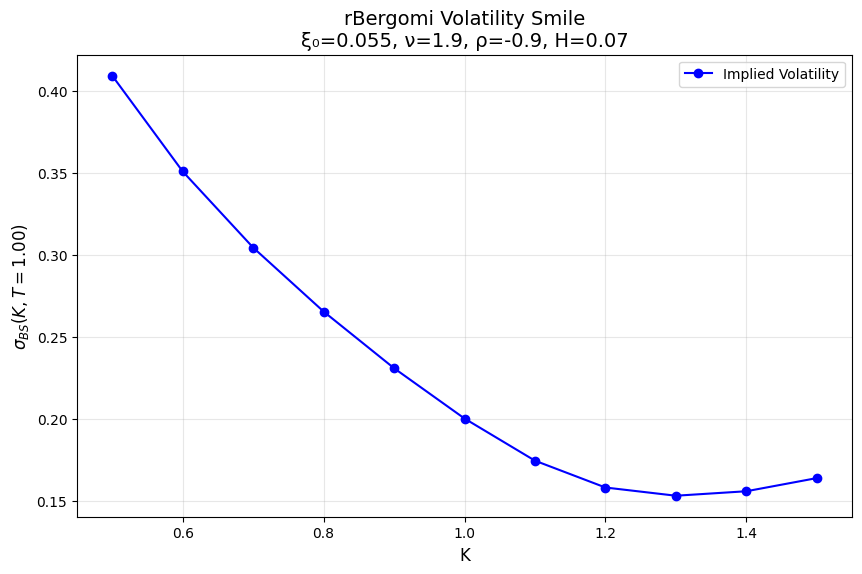

In [9]:
# Plot implied volatilities
plt.figure(figsize=(10, 6))
plt.plot(K, implied_vols, 'bo-', label='Implied Volatility')
plt.xlabel('K', fontsize=12)
plt.ylabel(r'$\sigma_{BS}(K,T=%.2f)$'%rB.T, fontsize=12)
plt.title(
    f"rBergomi Volatility Smile\n"
    f"ξ₀={rB.xi:.3f}, ν={rB.nu:.1f}, ρ={rB.rho:.1f}, H={rB.H:.2f}",
    fontsize=14
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Now we verify some properties of the processes $Y_t^H$, $V_t$ and $S_t$. Set the number of paths to observe and compute moments of the Volterra process: $$\mathbb{E}[Y_t^H] = 0,\quad \mathbb{V}\left[Y_t^H\right] = t^{2H}$$

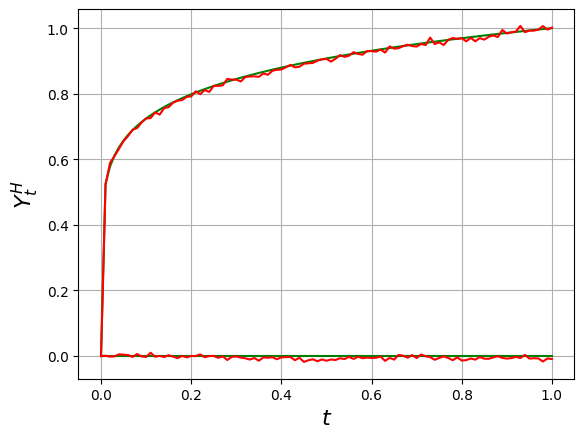

In [18]:
paths = 0
eY1 = 0 * rB.t # Known expectation
vY1 = rB.t**(2*rB.H) # Known variance
eY2 = np.mean(Y, axis=0, keepdims=True) # Observed expectation
vY2 = np.var(Y, axis=0, keepdims=True) # Observed variance
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], eY1[0,:], 'g')
axes.plot(rB.t[0,:], vY1[0,:], 'g')
axes.plot(rB.t[0,:], eY2[0,:], 'r')
axes.plot(rB.t[0,:], vY2[0,:], 'r')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(Y[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$Y^H_t$', fontsize=16)
plt.grid(True)

Now check the expectation of the variance process, $$\mathbb{E}[V_t] = \xi_0$$
And the expectation of price process (as long as the martingality), $$\mathbb{E}[S_t] = 1$$

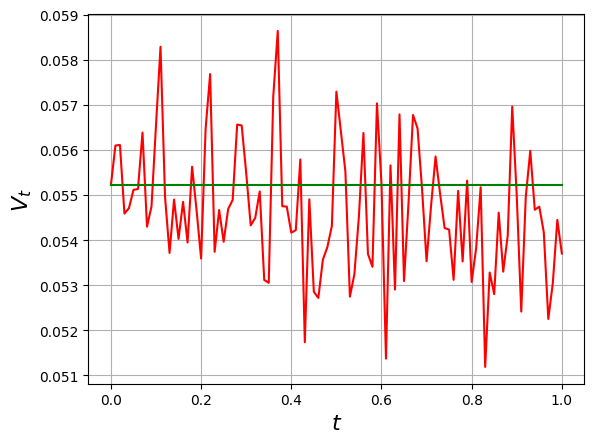

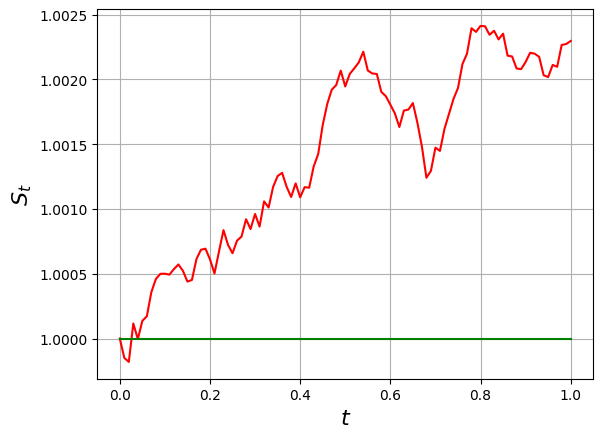

In [19]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], np.mean(V, axis = 0), 'r')
axes.plot(rB.t[0,:], 0.235**2 * np.ones_like(rB.t)[0,:], 'g')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(V[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$V_t$', fontsize=16)
plt.grid(True)

plot, axes = plt.subplots()
axes.plot(rB.t[0,:], np.mean(S, axis = 0), 'r')
axes.plot(rB.t[0,:], np.ones_like(rB.t[0,:]), 'g')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(S[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$S_t$', fontsize=16)
plt.grid(True)

# Comparison base MC versus mixed estimators MC
Below we'll make an extensive comparison between the usual Monte Carlo and the version with Mixed estimators, which can also leverage a simple, but unfortunately not efficient, antithetic variable tecnique. We'll compare them on prices, implied volatilities and execution times for different maturities. Here we define the methods.

In [9]:
def MC_Call_Mixed_prices(params, K, T,N=60000, r=0.0, S0=1.0, antithetic=False):
    """
    Monte Carlo simulation for call options under rBergomi model with implied vol calculation
    
    Args:
        strikes: Array of strike prices
        params: Array [ξ₀, ν, ρ, H] (variance params, correlation, Hurst exponent)
        T: Time to maturity
        r: Risk-free rate (default 0.0)
        S0: Initial spot price (default 1.0)
        N: Number of MC paths (default 60,000)
        n: Time steps per year (default 100)
        
    Returns:
        Array of implied volatilities for each strike
    """
    # Dynamically adjust the number of steps per year, crucial for short maturities
    n_steps = compute_steps_for_maturity(T)
    
    xi, nu, rho, H = params

    rB = rBergomi(n = n_steps, N = N, T = T, H = H)
    dW1 = rB.dW1()
    Ya = rB.Y(dW1)
    V = rB.V(Ya, xi = xi, nu = nu) 
    S1 = rB.S1(V, dW1, rho = rho)


    QV = np.sum(V, axis = 1)[:,np.newaxis] * rB.dt
    Q = np.max(QV) + 1e-9
    S1T = S1[:,-1][:,np.newaxis]
    X = bs(S1T, K, (1 - rho**2) * QV)
    Y = bs(S1T, K, rho**2 * (Q - QV))
    eY = bs(1., K, rho**2 * Q)
    m = len(K)
    c = np.zeros(m)
    for i in range(m):
        cov_mat = np.cov(X[:, i], Y[:, i])
        denom = cov_mat[1, 1]
        if denom == 0.0:
            c[i] = 0.0
        else:
            c[i] = - cov_mat[0, 1] / denom

    # 9) mixed payoffs and prices
    mixed_payoffs = X + (c[None, :] * (Y - eY[None, :]))  # (N, m)
    mixed_prices = np.mean(mixed_payoffs, axis=0)          # (m,)
    mixed_prices = np.maximum(mixed_prices, 1e-12)

    if antithetic:
        Yaav = rB.Y(-dW1)
        Vav = rB.V(Yaav, xi = xi, nu = nu) 
        S1av = rB.S1(Vav, -dW1, rho = rho)
        QVav = np.sum(Vav, axis = 1)[:,np.newaxis] * rB.dt
        Qav = np.max(QVav) + 1e-9
        S1Tav = S1av[:,-1][:,np.newaxis]
        Xav = bs(S1Tav, K, (1 - rho**2) * QVav)
        Yav = bs(S1Tav, K, rho**2 * (Qav - QVav))
        eYav = bs(1., K, rho**2 * Qav)
        cav = np.zeros(m)
        for i in range(m):
            cov_matav = np.cov(Xav[:, i], Yav[:, i])
            denom = cov_matav[1, 1]
            if denom == 0.0:
                cav[i] = 0.0
            else:
                cav[i] = - cov_matav[0, 1] / denom

        mixed_payoffsav = Xav + (cav[None, :] * (Yav - eYav[None, :]))  # (N, m)
        mixed_pricesav = np.mean((mixed_payoffs+mixed_payoffsav)/2, axis=0)          # (m,)
        mixed_pricesav = np.maximum(mixed_pricesav, 1e-12)
        mixed_ivsav = np.array([bsinv(p, 1.0, k, T) for p, k in zip(mixed_pricesav, K)])  # (m,)

        return mixed_pricesav, mixed_ivsav

    else:
        
        mixed_ivs = np.array([bsinv(p, 1.0, k, T) for p, k in zip(mixed_prices, K)])  # (m,)
        return mixed_prices, mixed_ivs

In [6]:
def MC_Call_Mixed_IV(params, K, T, N=50000, r=0.0, S0=1.0):
    """
    Monte Carlo simulation for call options under rBergomi model with implied vol calculation
    
    Args:
        strikes: Array of strike prices
        params: Array [ξ₀, ν, ρ, H] (variance params, correlation, Hurst exponent)
        T: Time to maturity
        r: Risk-free rate (default 0.0)
        S0: Initial spot price (default 1.0)
        N: Number of MC paths (default 60,000)
        n: Time steps per year (default 100)
        
    Returns:
        Dictionary with 'mean', 'lower_95', 'upper_95' arrays for implied vols at each strike
    """
    # Dynamically adjust the number of steps per year, crucial for short maturities
    n_steps = compute_steps_for_maturity(T)
    
    xi, nu, rho, H = params

    rB = rBergomi(n = n_steps, N = N, T = T, H = H)
    dW1 = rB.dW1()
    Ya = rB.Y(dW1)
    V = rB.V(Ya, xi = xi, nu = nu) 
    S1 = rB.S1(V, dW1, rho = rho)

    QV = np.sum(V, axis = 1)[:,np.newaxis] * rB.dt
    Q = np.max(QV) + 1e-9
    S1T = S1[:,-1][:,np.newaxis]
    X = bs(S1T, K, (1 - rho**2) * QV)
    Y = bs(S1T, K, rho**2 * (Q - QV))
    eY = bs(1., K, rho**2 * Q)
    m = len(K)
    c = np.zeros(m)
    for i in range(m):
        cov_mat = np.cov(X[:, i], Y[:, i])
        denom = cov_mat[1, 1]
        if denom == 0.0:
            c[i] = 0.0
        else:
            c[i] = - cov_mat[0, 1] / denom

    # 9) mixed payoffs and prices
    mixed_payoffs = X + (c[None, :] * (Y - eY[None, :]))  # (N, m)
    mixed_prices = np.mean(mixed_payoffs, axis=0)          # (m,)
    mixed_prices = np.maximum(mixed_prices, 1e-12)
    
    # Calcolo implied volatilities medie
    mixed_ivs = np.array([bsinv(p, 1.0, k, T) for p, k in zip(mixed_prices, K)])  # (m,)
    
    # Calcolo intervalli di confidenza al 95% per le implied volatilities
    std_errors = np.std(mixed_payoffs, axis=0) / np.sqrt(N)
    z_score = 1.96  # per 95% di confidenza
    
    # Intervalli di confidenza sui prezzi
    lower_prices = mixed_prices - z_score * std_errors
    upper_prices = mixed_prices + z_score * std_errors
    
    # Conversione degli intervalli in implied volatilities
    lower_ivs = np.array([bsinv(p, 1.0, k, T) for p, k in zip(lower_prices, K)])
    upper_ivs = np.array([bsinv(p, 1.0, k, T) for p, k in zip(upper_prices, K)])
    
    # Formato utile per il plotting
    results = {
        'strikes': K,
        'mean': mixed_ivs,
        'lower_95': lower_ivs,
        'upper_95': upper_ivs
    }
    
    return results

In [7]:
def MC_Call_Base_IV(params, strikes, T, N=50000, r=0.0, S0=1.0):
    """
    Monte Carlo simulation for call options under rBergomi model with implied vol calculation
    
    Args:
        strikes: Array of strike prices
        params: Array [ξ₀, ν, ρ, H] (variance params, correlation, Hurst exponent)
        T: Time to maturity
        r: Risk-free rate (default 0.0)
        S0: Initial spot price (default 1.0)
        N: Number of MC paths (default 60,000)
        n: Time steps per year (default 100)
        
    Returns:
        Dictionary with 'mean', 'lower_95', 'upper_95' arrays for implied vols at each strike
    """
    # Dynamically adjust the number of steps per year, crucial for short maturities
    n_steps = compute_steps_for_maturity(T)
    
    xi, nu, rho, H = params
    
    # Initialize rBergomi model
    rB = rBergomi(n=n_steps, N=N, T=T, H=H)
    
    # Generate Brownian motions
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    
    # Correlate Brownians
    dB = rB.dB(dW1, dW2, rho=rho)
    
    # Generate variance and price paths
    V = rB.V(Y, xi=xi, nu=nu) 
    S = rB.S(V, dB, S0=S0)
    
    # Calculate terminal payoffs
    ST = S[:,-1][:,np.newaxis]  # Terminal prices (N x 1)
    call_payoffs = np.maximum(ST - strikes[np.newaxis, :], 0)  # N x len(strikes)
    call_prices = np.mean(call_payoffs, axis=0)  # Expected payoff for each strike
    call_prices = np.maximum(call_prices, 1e-8) # Ensure no price is below 1e-8
    
    # Calcolo implied volatilities medie
    implied_vols = np.array([
        implied_volatility(
            market_price=price,
            S=S0,
            K=strike,
            T=T,
            r=r,
            option_type='call'
        )
        for price, strike in zip(call_prices, strikes)
    ])
    
    # Calcolo intervalli di confidenza al 95% per le implied volatilities
    std_errors = np.std(call_payoffs, axis=0) / np.sqrt(N)
    z_score = 1.96  # per 95% di confidenza
    
    # Intervalli di confidenza sui prezzi
    lower_prices = call_prices - z_score * std_errors
    upper_prices = call_prices + z_score * std_errors
    
    # Conversione degli intervalli in implied volatilities
    lower_ivs = np.array([
        implied_volatility(
            market_price=price,
            S=S0,
            K=strike,
            T=T,
            r=r,
            option_type='call'
        )
        for price, strike in zip(lower_prices, strikes)
    ])
    
    upper_ivs = np.array([
        implied_volatility(
            market_price=price,
            S=S0,
            K=strike,
            T=T,
            r=r,
            option_type='call'
        )
        for price, strike in zip(upper_prices, strikes)
    ])
    
    # Formato utile per il plotting
    results = {
        'strikes': strikes,
        'mean': implied_vols,
        'lower_95': lower_ivs,
        'upper_95': upper_ivs
    }
    
    return results

# Extensive comparison between Base MC vs Mixed estimator (+ Antithetic Variable)
In the snippet below we compare the 3 tecniques for a set of parameters, a strip of strikes and maturity **T = 1y**.

Base MC time: 1.8340s
Mixed MC time: 1.4198s

Params: ξ₀=0.0552, ν=1.9, ρ=-0.9, H=0.07


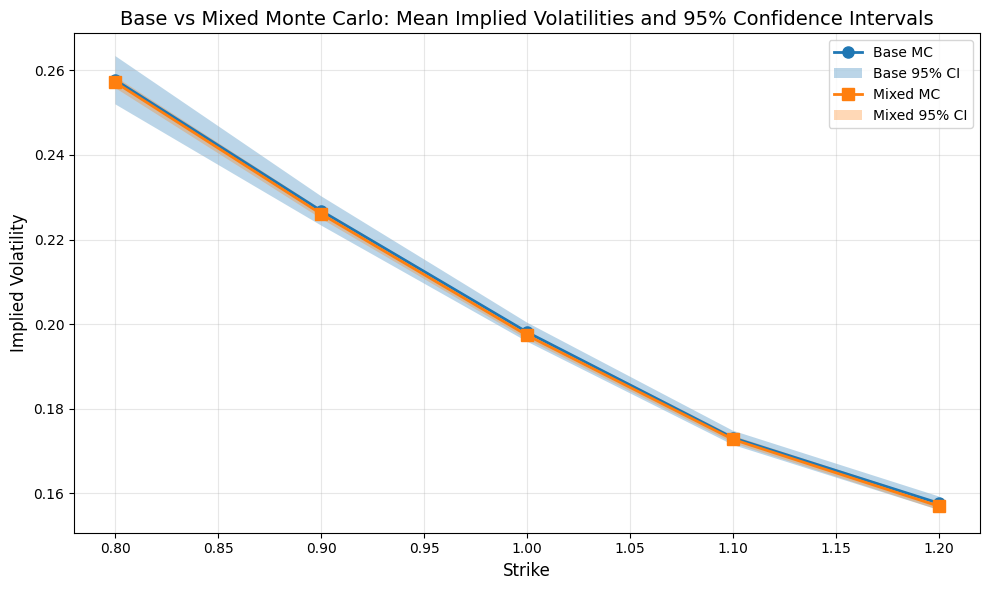

In [9]:
import time
from time import perf_counter

# Example parameters: ξ₀=0.235^2, ν=1.9, ρ=-0.9, H=0.07
params = np.array([0.235**2, 1.9, -0.9, 0.07])
strikes = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
T = 1.0  # 1y maturity

t0 = time.perf_counter()
results_base = MC_Call_Base_IV(params, strikes, T)
t1 = time.perf_counter()
time_base = t1 - t0

t0 = time.perf_counter()
results_mixed = MC_Call_Mixed_IV(params, strikes, T)
t1 = time.perf_counter()
time_mixed = t1 - t0

print(f"Base MC time: {time_base:.4f}s")
print(f"Mixed MC time: {time_mixed:.4f}s")
print(f"\nParams: ξ₀={params[0]:.4f}, ν={params[1]}, ρ={params[2]}, H={params[3]}")

# Plot
plt.figure(figsize=(10, 6))

# Base method
plt.plot(strikes, results_base['mean'], 'o-', label='Base MC', linewidth=2, markersize=8)
plt.fill_between(strikes, results_base['lower_95'], results_base['upper_95'], 
                 alpha=0.3, label='Base 95% CI')

# Mixed method
plt.plot(strikes, results_mixed['mean'], 's-', label='Mixed MC', linewidth=2, markersize=8)
plt.fill_between(strikes, results_mixed['lower_95'], results_mixed['upper_95'], 
                 alpha=0.3, label='Mixed 95% CI')

plt.xlabel('Strike', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title('Base vs Mixed Monte Carlo: Mean Implied Volatilities and 95% Confidence Intervals', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Compare with L2 norm the prices and implied volatilities differences between the 3 methods
diff_base_mixedav = np.linalg.norm(prices_base - prices_mixedav)
diff_mixed_mixedav = np.linalg.norm(prices_mixed - prices_mixedav)

# Compute also relative differences
rel_diff_base_mixedav = diff_base_mixedav / np.linalg.norm(prices_mixedav)
rel_diff_mixed_mixedav = diff_mixed_mixedav / np.linalg.norm(prices_mixedav)

print(f"Standard MC prices: ",prices_base)
print(f"\nMixed MC prices: ",prices_mixed)
print(f"\nMixed+AV MC prices: ",prices_mixedav)


print("\n--- Differences Analysis ---")
print(f"\nL2 norm between Base and Mixed+AV: {diff_base_mixedav:.6f} (relative: {rel_diff_base_mixedav:.2%})")
print(f"\nL2 norm between Mixed and Mixed+AV: {diff_mixed_mixedav:.6f} (relative: {rel_diff_mixed_mixedav:.2%})")

# Compare with L2 norm the implied volatilities differences between the 3 methods
diff_base_mixedav = np.linalg.norm(ivs_base - ivs_mixedav)
diff_mixed_mixedav = np.linalg.norm(ivs_mixed - ivs_mixedav)

# Compute also relative differences
rel_diff_base_mixedav = diff_base_mixedav / np.linalg.norm(ivs_mixedav)
rel_diff_mixed_mixedav = diff_mixed_mixedav / np.linalg.norm(ivs_mixedav)

print(f"\nStandard MC ivs: ",ivs_base)
print(f"\nMixed MC ivs: ",ivs_mixed)
print(f"\nMixed+AV MC ivs: ",ivs_mixedav)


print("\n--- Differences Analysis ---")
print(f"\nL2 norm between Base and Mixed+AV: {diff_base_mixedav:.6f} (relative: {rel_diff_base_mixedav:.2%})")
print(f"\nL2 norm between Mixed and Mixed+AV: {diff_mixed_mixedav:.6f} (relative: {rel_diff_mixed_mixedav:.2%})")

Standard MC prices:  [0.2250264  0.14524632 0.07939421 0.03365613 0.01079814]

Mixed MC prices:  [0.22464001 0.144955   0.07902739 0.03329954 0.01062228]

Mixed+AV MC prices:  [0.22464579 0.1449056  0.07892293 0.03315152 0.01047153]

--- Differences Analysis ---

L2 norm between Base and Mixed+AV: 0.000919 (relative: 0.33%)

L2 norm between Mixed and Mixed+AV: 0.000241 (relative: 0.09%)

Standard MC ivs:  [0.2598255  0.22807643 0.19934134 0.17467541 0.15869584]

Mixed MC ivs:  [0.25824295 0.22721411 0.19841728 0.17368178 0.15791231]

Mixed+AV MC ivs:  [0.25826668 0.22706782 0.19815416 0.17326883 0.15723652]

--- Differences Analysis ---

L2 norm between Base and Mixed+AV: 0.002994 (relative: 0.65%)

L2 norm between Mixed and Mixed+AV: 0.000848 (relative: 0.18%)


As we can see there are no relevant differences both in prices and implied volatilities, it's important to notice that the Mixed is the fastest method. 

the Antithetic Variable doesn't add relevant advantages since it takes much more time for roughly the same precision. Below we'll focus on **short maturities**.

Base MC time: 0.3634s
Mixed MC time: 0.5224s

Params: ξ₀=0.1047, ν=0.564144, ρ=-0.742971, H=0.244174
T = 0.0203675877985003


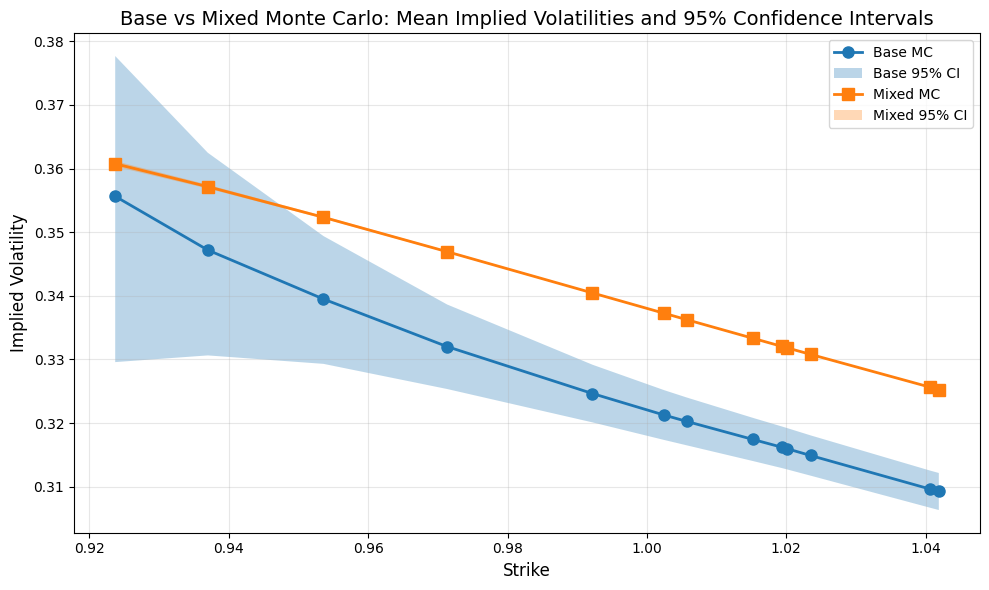

In [15]:
# Check for short maturity
params = random_grid_data[0,:4]
strikes = random_grid_data[0:13,4]
T = random_grid_data[0,5]

t0 = time.perf_counter()
results_base = MC_Call_Base_IV(params, strikes, T, N=50000)
t1 = time.perf_counter()
time_base = t1 - t0

t0 = time.perf_counter()
results_mixed = MC_Call_Mixed_IV(params, strikes, T)
t1 = time.perf_counter()
time_mixed = t1 - t0

print(f"Base MC time: {time_base:.4f}s")
print(f"Mixed MC time: {time_mixed:.4f}s")
print(f"\nParams: ξ₀={params[0]:.4f}, ν={params[1]}, ρ={params[2]}, H={params[3]}")
print(f"T = {T}")

# Plot
plt.figure(figsize=(10, 6))

# Base method
plt.plot(strikes, results_base['mean'], 'o-', label='Base MC', linewidth=2, markersize=8)
plt.fill_between(strikes, results_base['lower_95'], results_base['upper_95'], 
                 alpha=0.3, label='Base 95% CI')

# Mixed method
plt.plot(strikes, results_mixed['mean'], 's-', label='Mixed MC', linewidth=2, markersize=8)
plt.fill_between(strikes, results_mixed['lower_95'], results_mixed['upper_95'], 
                 alpha=0.3, label='Mixed 95% CI')

plt.xlabel('Strike', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title('Base vs Mixed Monte Carlo: Mean Implied Volatilities and 95% Confidence Intervals', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Compare with L2 norm the prices and implied volatilities differences between the 3 methods
diff_base_mixedav = np.linalg.norm(prices_base - prices_mixedav)
diff_mixed_mixedav = np.linalg.norm(prices_mixed - prices_mixedav)

# Compute also relative differences
rel_diff_base_mixedav = diff_base_mixedav / np.linalg.norm(prices_mixedav)
rel_diff_mixed_mixedav = diff_mixed_mixedav / np.linalg.norm(prices_mixedav)

print(f"Standard MC prices: ",prices_base)
print(f"\nMixed MC prices: ",prices_mixed)
print(f"\nMixed+AV MC prices: ",prices_mixedav)


print("\n--- Differences Analysis ---")
print(f"\nL2 norm between Base and Mixed+AV: {diff_base_mixedav:.6f} (relative: {rel_diff_base_mixedav:.2%})")
print(f"\nL2 norm between Mixed and Mixed+AV: {diff_mixed_mixedav:.6f} (relative: {rel_diff_mixed_mixedav:.2%})")

# Compare with L2 norm the implied volatilities differences between the 3 methods
diff_base_mixedav = np.linalg.norm(ivs_base - ivs_mixedav)
diff_mixed_mixedav = np.linalg.norm(ivs_mixed - ivs_mixedav)

# Compute also relative differences
rel_diff_base_mixedav = diff_base_mixedav / np.linalg.norm(ivs_mixedav)
rel_diff_mixed_mixedav = diff_mixed_mixedav / np.linalg.norm(ivs_mixedav)

print(f"\nStandard MC ivs: ",ivs_base)
print(f"\nMixed MC ivs: ",ivs_mixed)
print(f"\nMixed+AV MC ivs: ",ivs_mixedav)


print("\n--- Differences Analysis ---")
print(f"\nL2 norm between Base and Mixed+AV: {diff_base_mixedav:.6f} (relative: {rel_diff_base_mixedav:.2%})")
print(f"\nL2 norm between Mixed and Mixed+AV: {diff_mixed_mixedav:.6f} (relative: {rel_diff_mixed_mixedav:.2%})")

Standard MC prices:  [0.07809492 0.06186912 0.0562902  0.04686495 0.03810691 0.02792789
 0.02660239 0.02624111 0.02265748 0.01619933 0.01306778 0.00630765
 0.00547399]

Mixed MC prices:  [0.07898157 0.06294953 0.05744023 0.0481171  0.03943866 0.02929713
 0.02796944 0.02760713 0.02400244 0.0174459  0.01423697 0.00713715
 0.0062372 ]

Mixed+AV MC prices:  [0.0789826  0.06295235 0.05744351 0.0481206  0.03944149 0.02929796
 0.02796993 0.02760753 0.02400185 0.0174436  0.01423407 0.00713456
 0.0062349 ]

--- Differences Analysis ---

L2 norm between Base and Mixed+AV: 0.004271 (relative: 2.95%)

L2 norm between Mixed and Mixed+AV: 0.000008 (relative: 0.01%)

Standard MC ivs:  [0.32387542 0.32568202 0.32541039 0.32443951 0.32273463 0.31995741
 0.31952665 0.31940694 0.31815698 0.31547537 0.31374439 0.30903685
 0.30826802]

Mixed MC ivs:  [0.35917381 0.35411172 0.35223375 0.34885249 0.3454116  0.34086472
 0.34021113 0.34002984 0.33814906 0.33425331 0.33201341 0.32547666
 0.32435658]

Mixed+AV M

As we can see the tiny differences in prices, that we can only notice through a relative comparison, which in reality are huge, play a crucial rule in the IV smirk, this is because for short maturities we have an **explosion of variance** that is not well captured by standard Monte Carlo, this can result as we see in unrealistic/**not arbitrage free** smiles.

Below we'll compare an entire IV surface


 Base MC time: 32.338190999998915


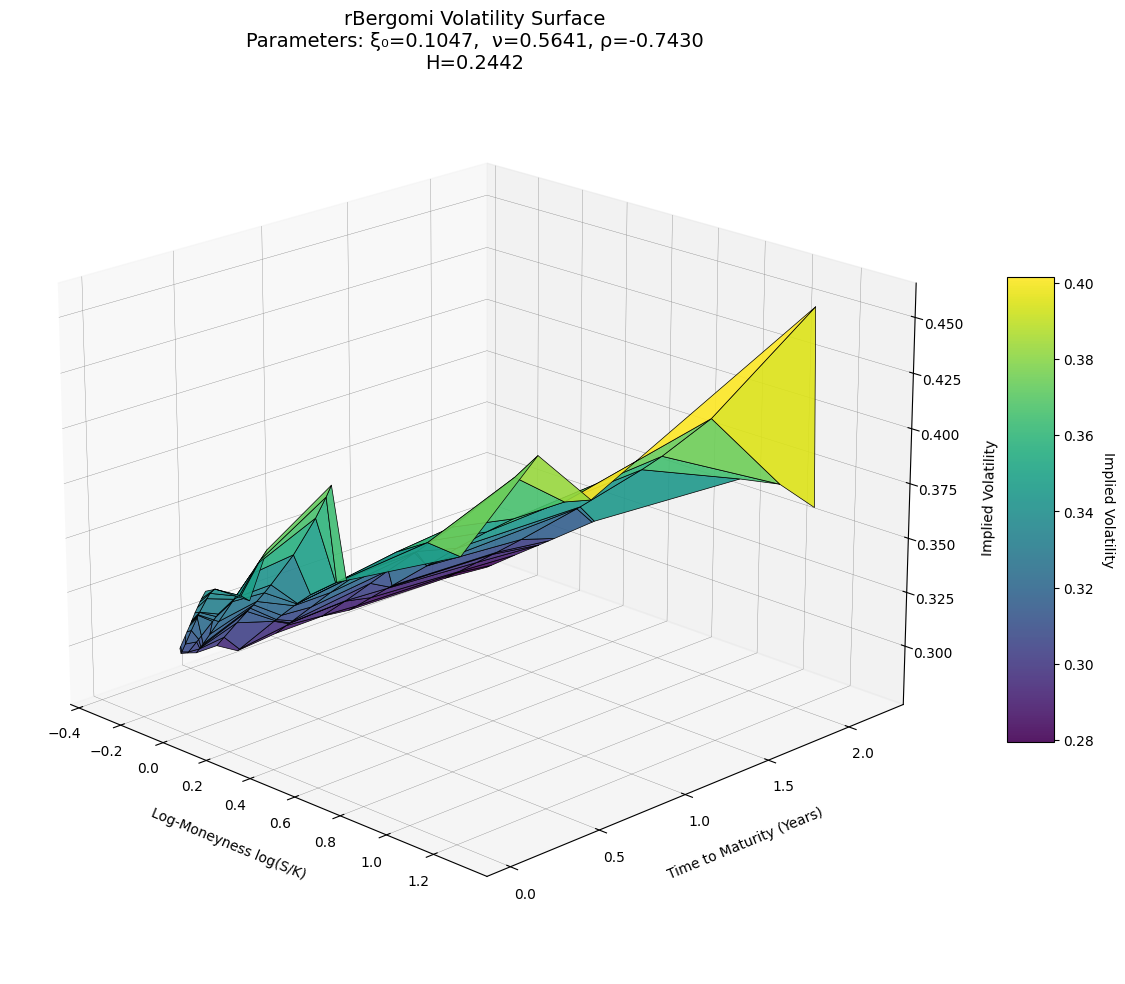

In [30]:
params = random_grid_data[0,:4]
t0 = time.perf_counter()
implied_vols_base=np.zeros(143)
for i in range(11):
    T = random_grid_data[i*13,5]
    strikes = random_grid_data[i*13:i*13+13,4]
    _ , ivs_base =  MC_Call_IV(params, strikes, T) 
    implied_vols_base[i*13:i*13+13] = ivs_base
t1 = time.perf_counter()
time_base = t1-t0
print(f"\n Base MC time: {time_base}")
plot_rBergomi_vol_surface(random_grid_data[:143], implied_vols_base, param_set_idx=0, use_log_moneyness=True)


Mixed AV MC time: 57.51251779999802


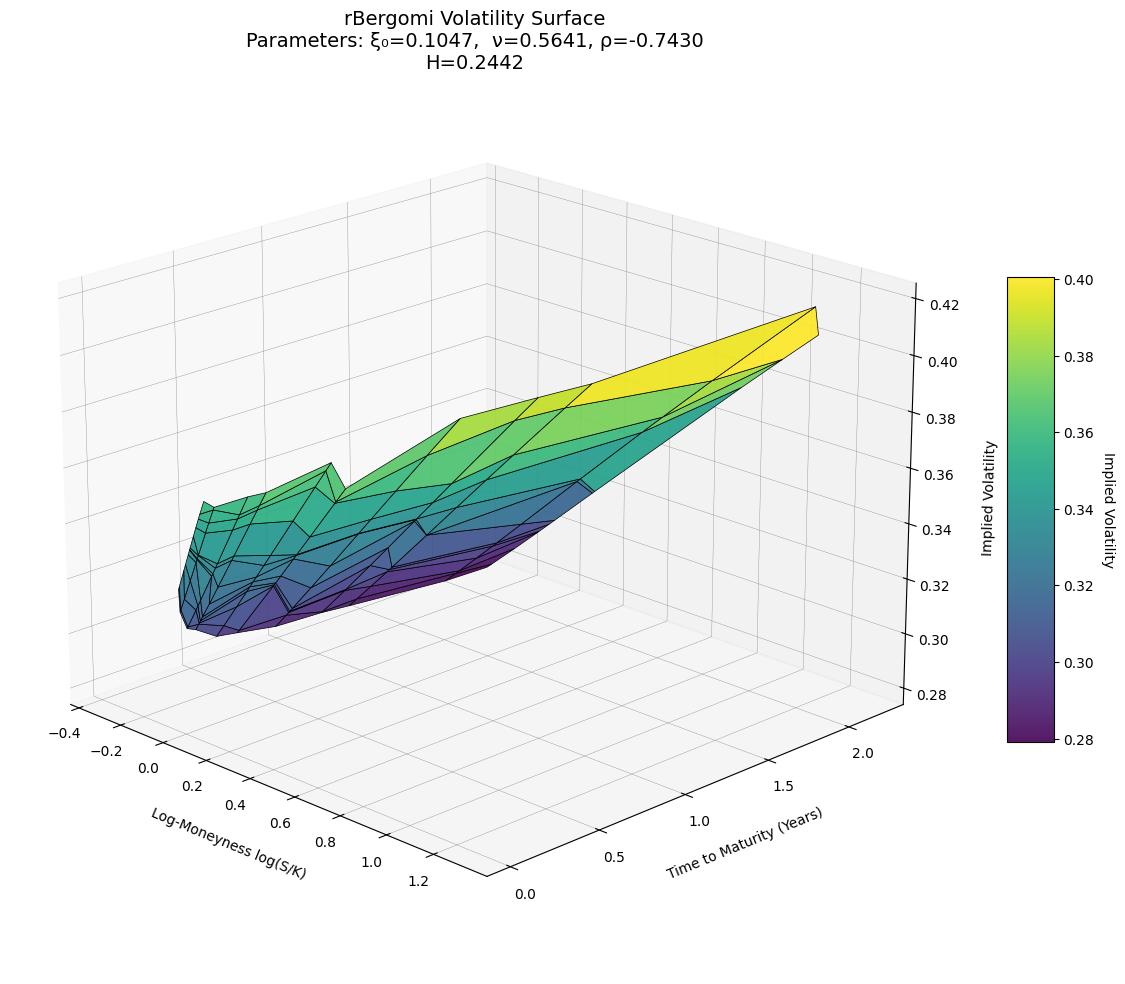

In [29]:
params = random_grid_data[0,:4]
t0 = time.perf_counter()
implied_vols_mixed_av=np.zeros(143)
for i in range(11):
    T = random_grid_data[i*13,5]
    strikes = random_grid_data[i*13:i*13+13,4]
    _ , ivs_mixedav = MC_Call_Mixed_prices(params, strikes, T, antithetic=True)
    implied_vols_mixed_av[i*13:i*13+13] = ivs_mixedav
t1 = time.perf_counter()
time_mixed_av = t1-t0
print(f"\nMixed AV MC time: {time_mixed_av}")
plot_rBergomi_vol_surface(random_grid_data[:143], implied_vols_mixed_av, param_set_idx=0, use_log_moneyness=True)


Mixed MC time: 31.932530300000508


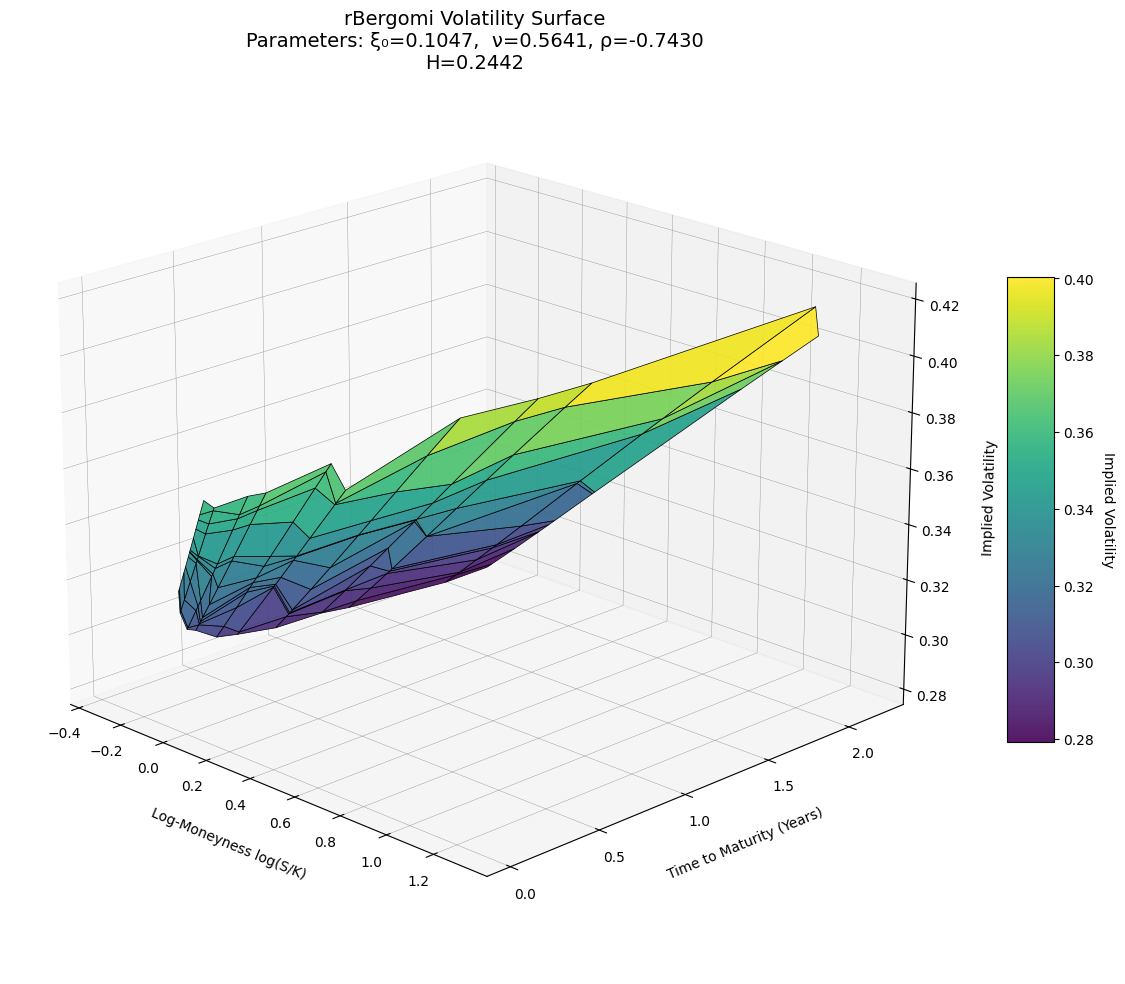

In [28]:
params = random_grid_data[0,:4]
t0 = time.perf_counter()
implied_vols_mixed=np.zeros(143)
for i in range(11):
    T = random_grid_data[i*13,5]
    strikes = random_grid_data[i*13:i*13+13,4]
    _ , ivs_mixed = MC_Call_Mixed_prices(params, strikes, T, antithetic=False)
    implied_vols_mixed[i*13:i*13+13] = ivs_mixed
t1 = time.perf_counter()
time_mixed = t1-t0
print(f"\nMixed MC time: {time_mixed}")
plot_rBergomi_vol_surface(random_grid_data[:143], implied_vols_mixed, param_set_idx=0, use_log_moneyness=True)

=== GLOBAL ERRORS ===
L2 Norm (Base vs Mixed+AV): 0.127299
L2 Norm (Mixed vs Mixed+AV): 0.002848

Relative Error (Base vs Mixed+AV): 2.06%
Relative Error (Mixed vs Mixed+AV): 0.06%

=== ERRORS BY MATURITY ===

Maturity 0.0286 years:
L2: Base=0.0593, Mixed=0.0015
Rel: Base=4.80%, Mixed=0.11%

Maturity 0.0427 years:
L2: Base=0.0389, Mixed=0.0001
Rel: Base=3.13%, Mixed=0.01%

Maturity 0.1285 years:
L2: Base=0.0394, Mixed=0.0009
Rel: Base=2.72%, Mixed=0.07%

Maturity 0.1776 years:
L2: Base=0.0124, Mixed=0.0004
Rel: Base=1.05%, Mixed=0.04%

Maturity 0.3612 years:
L2: Base=0.0232, Mixed=0.0003
Rel: Base=1.11%, Mixed=0.02%

Maturity 0.5066 years:
L2: Base=0.0371, Mixed=0.0007
Rel: Base=2.76%, Mixed=0.06%

Maturity 0.7696 years:
L2: Base=0.0365, Mixed=0.0008
Rel: Base=1.46%, Mixed=0.07%

Maturity 1.0554 years:
L2: Base=0.0060, Mixed=0.0006
Rel: Base=0.25%, Mixed=0.05%

Maturity 1.2529 years:
L2: Base=0.0264, Mixed=0.0010
Rel: Base=1.30%, Mixed=0.08%

Maturity 1.9085 years:
L2: Base=0.0416, Mix

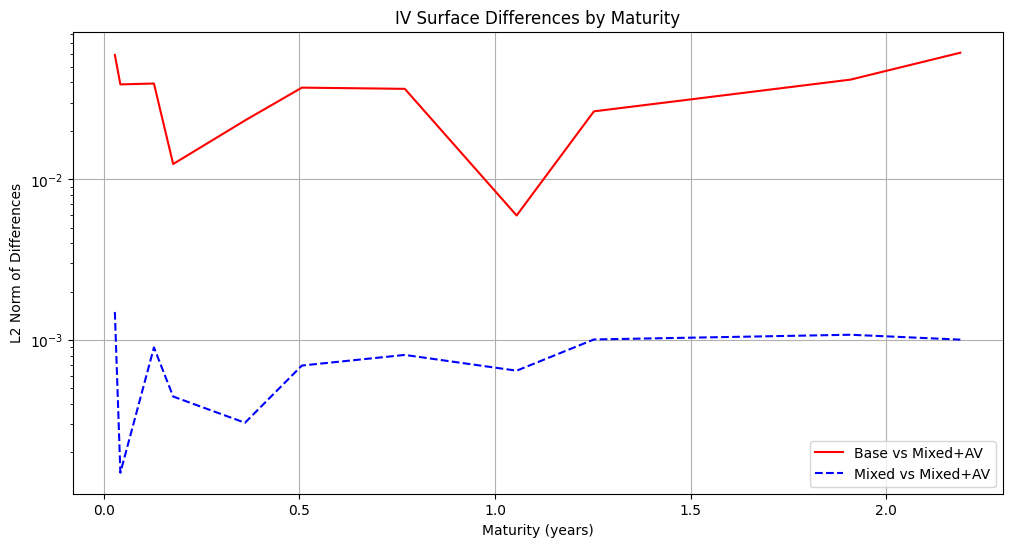

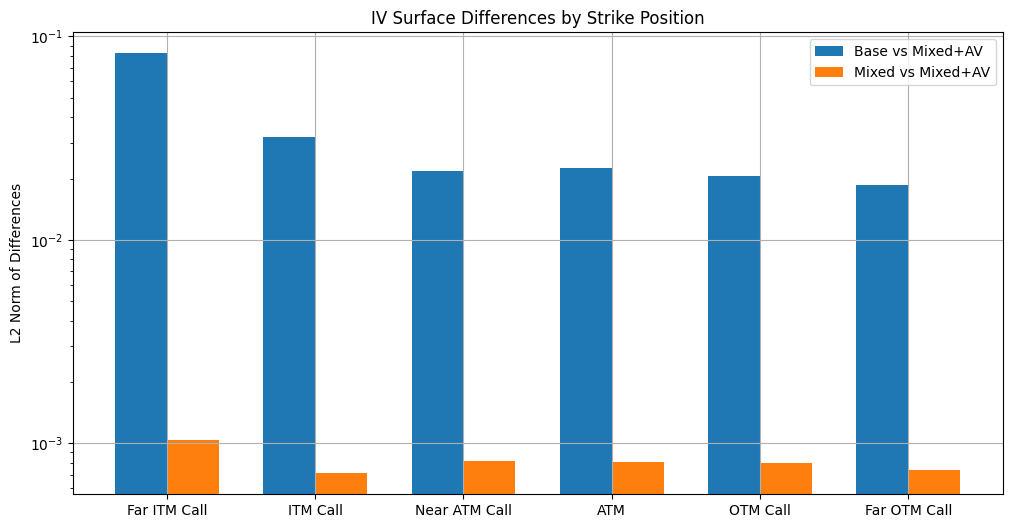

In [34]:
from sklearn.metrics import mean_squared_error

# 1. Organize data in matrices 11x13 (maturities x strikes)
n_maturities = 11
n_strikes = 13

def reshape_to_surface(data):
    return data.reshape(n_maturities, n_strikes)

iv_base = reshape_to_surface(implied_vols_base)
iv_mixed = reshape_to_surface(implied_vols_mixed)
iv_mixedav = reshape_to_surface(implied_vols_mixed_av)

# 2. Compute L2 norm and relative error
global_l2_base = np.linalg.norm(iv_base - iv_mixedav)
global_l2_mixed = np.linalg.norm(iv_mixed - iv_mixedav)

global_rel_base = np.mean(np.abs(iv_base - iv_mixedav)/iv_mixedav)
global_rel_mixed = np.mean(np.abs(iv_mixed - iv_mixedav)/iv_mixedav)

print("=== GLOBAL ERRORS ===")
print(f"L2 Norm (Base vs Mixed+AV): {global_l2_base:.6f}")
print(f"L2 Norm (Mixed vs Mixed+AV): {global_l2_mixed:.6f}")
print(f"\nRelative Error (Base vs Mixed+AV): {global_rel_base:.2%}")
print(f"Relative Error (Mixed vs Mixed+AV): {global_rel_mixed:.2%}")

# 3. Analisis per maturity
print("\n=== ERRORS BY MATURITY ===")
data = random_grid_data[:143,:]
maturities = data[::13,5]

for i, T in enumerate(maturities):
    l2_base = np.linalg.norm(iv_base[i,:] - iv_mixedav[i,:])
    l2_mixed = np.linalg.norm(iv_mixed[i,:] - iv_mixedav[i,:])
    
    rel_base = np.mean(np.abs(iv_base[i,:] - iv_mixedav[i,:])/iv_mixedav[i,:])
    rel_mixed = np.mean(np.abs(iv_mixed[i,:] - iv_mixedav[i,:])/iv_mixedav[i,:])
    
    print(f"\nMaturity {T:.4f} years:")
    print(f"L2: Base={l2_base:.4f}, Mixed={l2_mixed:.4f}")
    print(f"Rel: Base={rel_base:.2%}, Mixed={rel_mixed:.2%}")

# 4. Analisis per strike
print("\n=== ERRORS BY STRIKE POSITION ===")
strike_positions = {
    'Far ITM Call': 0,
    'ITM Call': 3,
    'Near ATM Call': 5,
    'ATM': 6,  
    'Near ATM Call': 7,
    'OTM Call': 9,
    'Far OTM Call': 12
}

for name, idx in strike_positions.items():
    l2_base = np.linalg.norm(iv_base[:,idx] - iv_mixedav[:,idx])
    l2_mixed = np.linalg.norm(iv_mixed[:,idx] - iv_mixedav[:,idx])
    
    rel_base = np.mean(np.abs(iv_base[:,idx] - iv_mixedav[:,idx])/iv_mixedav[:,idx])
    rel_mixed = np.mean(np.abs(iv_mixed[:,idx] - iv_mixedav[:,idx])/iv_mixedav[:,idx])
    
    print(f"\n{name} (Position {idx+1}):")
    print(f"L2: Base={l2_base:.4f}, Mixed={l2_mixed:.4f}")
    print(f"Rel: Base={rel_base:.2%}, Mixed={rel_mixed:.2%}")

# 5. Visualize differences

# Plot differences per maturity
plt.figure(figsize=(12,6))
plt.plot(maturities, np.linalg.norm(iv_base - iv_mixedav, axis=1), 'r-', label='Base vs Mixed+AV')
plt.plot(maturities, np.linalg.norm(iv_mixed - iv_mixedav, axis=1), 'b--', label='Mixed vs Mixed+AV')
plt.yscale('log')
plt.xlabel('Maturity (years)')
plt.ylabel('L2 Norm of Differences')
plt.title('IV Surface Differences by Maturity')
plt.legend()
plt.grid(True)
plt.show()

# Plot differences per strike
plt.figure(figsize=(12,6))
x_pos = np.arange(len(strike_positions))
width = 0.35

base_diffs = [np.linalg.norm(iv_base[:,idx] - iv_mixedav[:,idx]) for idx in strike_positions.values()]
mixed_diffs = [np.linalg.norm(iv_mixed[:,idx] - iv_mixedav[:,idx]) for idx in strike_positions.values()]

plt.bar(x_pos - width/2, base_diffs, width, label='Base vs Mixed+AV')
plt.bar(x_pos + width/2, mixed_diffs, width, label='Mixed vs Mixed+AV')
plt.yscale('log')
plt.xticks(x_pos, strike_positions.keys())
plt.ylabel('L2 Norm of Differences')
plt.title('IV Surface Differences by Strike Position')
plt.legend()
plt.grid(True)
plt.show()